# Udacity Data Scientist Nanodegree: Project 1-1 - Write a Data Science Blog Post


For this project I will be using the dataset available for the Kaggle competition "Seattle Airbnb Open Data", available here: https://www.kaggle.com/airbnb/seattle.

#### About Airbnb: 
"A‌i‌r‌b‌n‌b‌,‌ ‌I‌n‌c‌.‌ is an online marketplace for arranging or offering lodging, primarily homestays, or tourism experiences. The company does not own any of the real estate listings, nor does it host events; it acts as a broker, receiving commissions from each booking.[4] The company is based in San Francisco, California, United States.

The company was conceived after its founders put an air mattress in their living room, effectively turning their apartment into a bed and breakfast, in order to offset the high cost of rent in San Francisco; Airbnb is a shortened version of its original name, AirBedandBreakfast.com." <br>
<i>(Source: https://en.wikipedia.org/wiki/Airbnb)</i>

## Data Analysis
First I am going to import the necessary packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
import seaborn as sns
%matplotlib inline

base_color = sns.color_palette()[0]


### Gathering the data from csv files

In [2]:
dfSeattleListings = pd.read_csv('airbnb_seattle_listings.csv')

### Defining some Helper Functions

In [3]:
def makeCountplot(df, col, xlabel, rotation):
    n_points = df.shape[0]
    max_count = df[col].value_counts().max()
    max_prop = max_count / n_points

    # generate tick mark locations and names
    tick_props = np.arange(0, max_prop +0.05, 0.05)
    tick_names = ['{:0.2f}'.format(v) for v in tick_props]

    # create the plot
    base_color = sns.color_palette()[0]
    sns.countplot(data=df, x=col, color=base_color)
    plt.xticks(rotation=rotation)
    plt.yticks(tick_props * n_points, tick_names)
    plt.ylabel('Proportion')
    plt.xlabel(xlabel)

def create_dummy_df(df:pd.DataFrame, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating
    '''
    for col in cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True,
                                           dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

def to_int(x):
    '''
    Columns value corrections
    INPUT:
    x - value that should be corrected
    OUTPUT:
    x converted to an integer representation (0/1)
    '''
    if x=='f':
        x=x.replace('f','0')
    elif x=='t':
        x=x.replace('t','1')
    else:
        x= '0'
    return int(x)

def convertStrToBoolean(df):
    '''
    Changes the string of boolean (t / f) into int of boolean (1/0)
    INPUT:
    df - pandas dataframe with variables containing a string of boolean (t / f)
    OUTPUT:
    df - a new dataframe including the converted columns
    '''
    # Change the string of boolean (t / f) into int of boolean (1/0)
    for i in df.columns:  
        if set(df[i])=={'t','f'} or set(df[i]) == {'t','f',np.nan}:
            df[i]=df[i].apply(to_int)
    return df

def convertAmenities(x):
    '''
    Converts the Amenities column into more analytical words
    '''
    val = x.replace('{','').replace('}','').replace('"','').replace(' ','_').replace(',',' ')
    val = val.split()
    return val

def plotFeatureImportance(df, model):
    plt.figure(figsize=(12, 20))
    feature_importance = model.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, df.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
def fitAndScoreModel(X_train, y_train, model):
    model.fit(X_train, y_train)
    y_test_preds = model.predict(X_test)
    y_train_preds = model.predict(X_train)

    # Score using our model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    rmse = sqrt(mean_squared_error(y_test, model.predict(X_test)))
    print(f'test score: {test_score}')
    print(f'train score: {train_score}')
    print("RMSE: %.4f" % rmse)
    return model, test_score, train_score, rmse

def plotPredVsResiduals(model, model_name):
    y_test_preds = model.predict(X_test)
    y_train_preds = model.predict(X_train)

    plt.scatter(y_train_preds,  y_train_preds - y_train,
                c='blue', marker='o', label='Training data')
    plt.scatter(y_test_preds,  y_test_preds - y_test,
                c='lightgreen', marker='s', label='Test data')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.title(model_name + ' - Predicted values vs. Residuals')
    plt.show()

## Exploration
First we'll look at the size of the dataset.

In [4]:
num_rows = dfSeattleListings.shape[0] 
num_cols = dfSeattleListings.shape[1] 
print(f'There are {num_rows} rows and {num_cols} columns in the dataset!')


There are 3818 rows and 92 columns in the dataset!


Get a sneak peak at the dataset

In [5]:
dfSeattleListings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [6]:
dfSeattleListings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


In [7]:
dfSeattleListings.columns.values

array(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name',
       'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'market', 'smart_location', 'country_code', 'country', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       

In [8]:
# % of NaN values
cols = []
for col in dfSeattleListings.columns:
    cols.append([col,round((len(dfSeattleListings[col])-dfSeattleListings[col].count())/len(dfSeattleListings[col])*100, 2)])
cols = sorted(cols, key=lambda x:x[1], reverse=True)
cols

[['license', 100.0],
 ['square_feet', 97.46],
 ['monthly_price', 60.27],
 ['security_deposit', 51.13],
 ['weekly_price', 47.38],
 ['notes', 42.06],
 ['neighborhood_overview', 27.03],
 ['cleaning_fee', 26.98],
 ['transit', 24.46],
 ['host_about', 22.5],
 ['host_acceptance_rate', 20.25],
 ['review_scores_accuracy', 17.23],
 ['review_scores_checkin', 17.23],
 ['review_scores_value', 17.18],
 ['review_scores_location', 17.16],
 ['review_scores_cleanliness', 17.1],
 ['review_scores_communication', 17.05],
 ['review_scores_rating', 16.95],
 ['first_review', 16.42],
 ['last_review', 16.42],
 ['reviews_per_month', 16.42],
 ['space', 14.9],
 ['host_response_time', 13.7],
 ['host_response_rate', 13.7],
 ['neighbourhood', 10.9],
 ['thumbnail_url', 8.38],
 ['medium_url', 8.38],
 ['xl_picture_url', 8.38],
 ['host_neighbourhood', 7.86],
 ['summary', 4.64],
 ['bathrooms', 0.42],
 ['host_location', 0.21],
 ['zipcode', 0.18],
 ['bedrooms', 0.16],
 ['host_name', 0.05],
 ['host_since', 0.05],
 ['host_is_

Text(0.5, 0, 'Number of NA values')

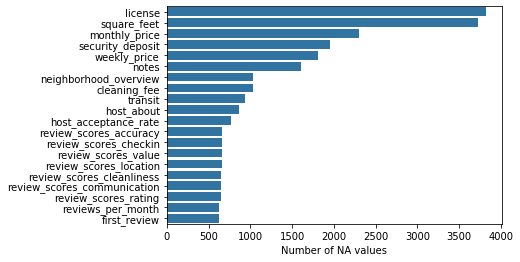

In [9]:
na_counts = dfSeattleListings.isna().sum().sort_values(ascending=False)
sns.barplot(na_counts[:20], na_counts[:20].index.values, color = base_color);
plt.xlabel('Number of NA values')

In [10]:
dfSeattleListings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

Here I am going to focus on the most interesting seeming columns ("square_feet" would be interesting too but we'll drop this due to lots of missing values).

In [11]:
cols=['experiences_offered', 'host_response_time', 'host_response_rate', 
      'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
      'host_has_profile_pic', 'host_identity_verified', 'zipcode', 'property_type', 'room_type', 
      'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities', 'price', 'number_of_reviews',
     'review_scores_rating', 'reviews_per_month']
df = dfSeattleListings[cols]
df.tail(5)

,experiences_offered,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,zipcode,...,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,number_of_reviews,review_scores_rating,reviews_per_month
3813,none,within a few hours,99%,100%,f,354.0,354.0,t,t,98107,...,Entire home/apt,6,2.0,3.0,3.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$359.00,1,80.0,0.3
3814,none,within an hour,100%,100%,f,1.0,1.0,t,t,98102,...,Entire home/apt,4,1.0,1.0,2.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",$79.00,2,100.0,2.0
3815,none,NaN,NaN,NaN,f,1.0,1.0,t,f,98178,...,Entire home/apt,2,1.0,1.0,1.0,"{""Cable TV"",""Wireless Internet"",Kitchen,""Free ...",$93.00,0,NaN,NaN
3816,none,within an hour,100%,NaN,f,1.0,1.0,t,t,98112,...,Entire home/apt,2,1.0,0.0,1.0,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",$99.00,0,NaN,NaN
3817,none,within a day,100%,NaN,f,1.0,1.0,t,t,98109,...,Entire home/apt,3,1.5,2.0,1.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",$87.00,0,NaN,NaN


## Cleaning data

First I am going to convert the non-categorical string columns to numeric columns and also convert the string-formatted Boolean columns to numerically formatted columns.

In [12]:
pd.options.mode.chained_assignment = None  # default='warn'
df['host_response_rate'] = df['host_response_rate'].astype(str)
df['host_response_rate'] = df['host_response_rate'].str.replace("%", "").astype("float")

df['host_acceptance_rate'] = df['host_acceptance_rate'].astype(str)
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace("%", "").astype("float")

df['price'] = df['price'].astype(str)
df['price'] = df['price'].str.replace("[$, ]", "").astype("float")

df['host_is_superhost']=np.where(df['host_is_superhost']=='t',1,0)
df['host_has_profile_pic']=np.where(df['host_has_profile_pic']=='t',1,0)
df['host_identity_verified']=np.where(df['host_identity_verified']=='t',1,0)

In [13]:
print(df['experiences_offered'].value_counts())
#dropping "experiences_offered" since it only contains 1 value
df = df.drop(['experiences_offered'], axis=1)

none    3818
Name: experiences_offered, dtype: int64


In [14]:
#df = df.dropna(subset=['price'])   #Drop only if NaN in specific column

Here I'm just looking at different categorical variables to determine wether or not I will create dummy variables for them or not.

In [15]:
df['property_type'].value_counts()

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Bungalow             13
Camper/RV            13
Boat                  8
Tent                  5
Treehouse             3
Chalet                2
Dorm                  2
Yurt                  1
Name: property_type, dtype: int64

In [16]:
df['room_type'].value_counts()

Entire home/apt    2541
Private room       1160
Shared room         117
Name: room_type, dtype: int64

In [17]:
print(df['amenities'].value_counts())

{}                                                                                                                                                                                                                                                                                                      45
{Internet,"Wireless Internet",Kitchen,"Free Parking on Premises",Heating,Washer,Dryer}                                                                                                                                                                                                                  11
{TV,"Cable TV",Internet,"Wireless Internet",Pool,Kitchen,"Free Parking on Premises",Gym,"Elevator in Building","Hot Tub",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","Fire Extinguisher",Essentials,Shampoo,"24-Hour Check-in",Hangers,"Hair Dryer",Iron}    10
{TV,"Cable TV",Internet,"Wireless Internet",Kitchen,"Buzzer/Wireless Intercom",Heating,Washer,Dryer,Ess

Let's try to clean the amenities column and to convert it to something useful. I am interested if th amount of amenities has an effect on the price.


In [18]:
df['amenities_len'] = df['amenities'].apply(lambda x: len(convertAmenities(x)))
df = df.drop(['amenities'], axis=1)

Text(0, 0.5, 'Count')

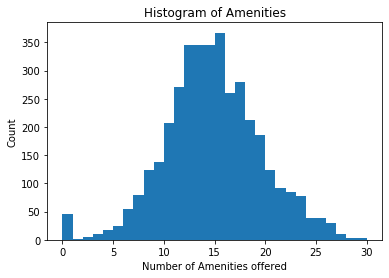

In [19]:
plt.hist(df['amenities_len'], 30)
plt.title('Histogram of Amenities')
plt.xlabel('Number of Amenities offered')
plt.ylabel('Count')

## What difference does it make if the host is considered a "superhost" by Airbnb?

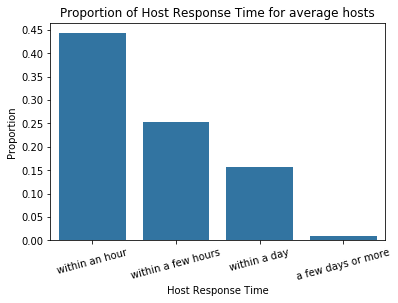

In [20]:
responseTimeClasses = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']
vclasses = pd.api.types.CategoricalDtype(ordered = True, categories = responseTimeClasses)
df['host_response_time'] = df['host_response_time'].astype(vclasses)
makeCountplot(df, 'host_response_time', 'Host Response Time', 15)
plt.title('Proportion of Host Response Time for average hosts');

Most Airbnb Hosts answer requests very quickly, almost half of them answer within an hour.
I wonder if superhosts answer even faster than normal hosts.

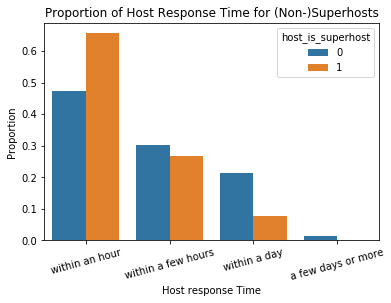

In [21]:
x, y, hue = "host_response_time", "Proportion", "host_is_superhost"

prop_df = (df[x]
           .groupby(df[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

sns.barplot(x=x, y=y, hue=hue, data=prop_df)
plt.xticks(rotation=15)
plt.xlabel('Host response Time')
plt.title('Proportion of Host Response Time for (Non-)Superhosts')
plt.show()

In [22]:
dfsuper = df[['host_is_superhost', 'price', 'review_scores_rating', 'amenities_len', 'host_listings_count']]
dfsuper = dfsuper.groupby(by=['host_is_superhost']).mean()
dfsuper

,price,review_scores_rating,amenities_len,host_listings_count
host_is_superhost,,,,
0,127.422368,93.652893,14.108882,7.740948
1,130.140103,97.395473,15.335476,4.880463


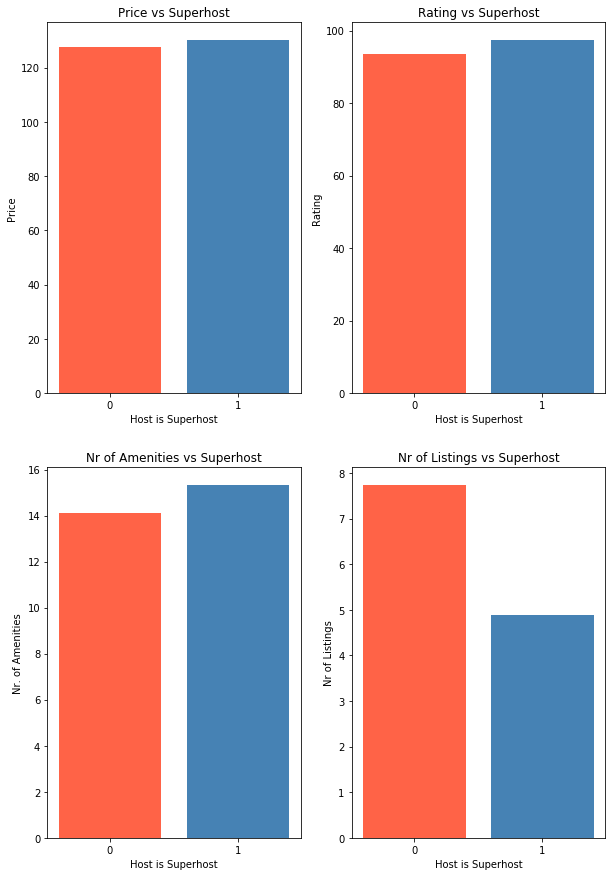

In [23]:
plt.figure(figsize = [10, 15]) 
color=['tomato', 'steelblue']
plt.subplot(2, 2, 1)
#bin_edges = np.arange(0, df['num_var'].max()+4, 4)
plt.bar(x=dfsuper.index, height=dfsuper['price'], color=color)
plt.xticks([0,1])
plt.xlabel('Host is Superhost')
plt.ylabel('Price')
plt.title('Price vs Superhost')

plt.subplot(2, 2, 2) 
plt.bar(x=dfsuper.index, height=dfsuper['review_scores_rating'], color=color)
plt.xticks([0,1])
plt.xlabel('Host is Superhost')
plt.ylabel('Rating')
plt.title('Rating vs Superhost')

plt.subplot(2, 2, 3)
plt.bar(x=dfsuper.index, height=dfsuper['amenities_len'], color=color)
plt.xticks([0,1])
plt.xlabel('Host is Superhost')
plt.ylabel('Nr. of Amenities')
plt.title('Nr of Amenities vs Superhost')

plt.subplot(2, 2, 4)
plt.bar(x=dfsuper.index, height=dfsuper['host_listings_count'], color=color)
plt.xticks([0,1])
plt.xlabel('Host is Superhost')
plt.ylabel('Nr of Listings')
plt.title('Nr of Listings vs Superhost')
plt.show()

## What is the average price per zip code for Airbnb listings in Seattle?

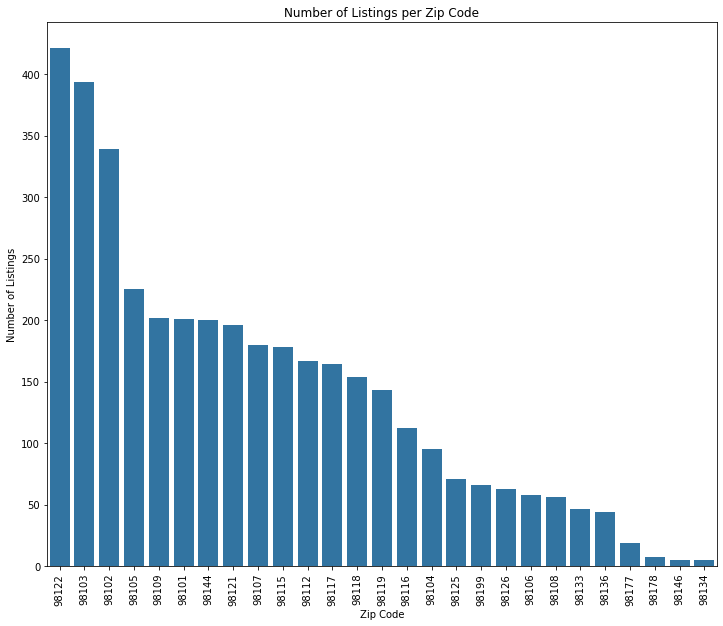

In [24]:
dfgeo = dfSeattleListings[['zipcode', 'price']]
dfgeo['price'] = dfgeo['price'].astype(str)
dfgeo['price'] = dfgeo['price'].str.replace("[$, ]", "").astype("float")
dfgeo['zipcode'] = dfgeo['zipcode'].replace('99\n98122','98122')
dfgeo = dfgeo.dropna()
plt.figure(figsize=(12, 10))
sns.countplot(dfgeo['zipcode'], color=base_color, order = dfgeo['zipcode'].value_counts().index);
plt.xticks(rotation=90)
plt.title('Number of Listings per Zip Code')
plt.xlabel('Zip Code')
plt.ylabel('Number of Listings')
plt.show()


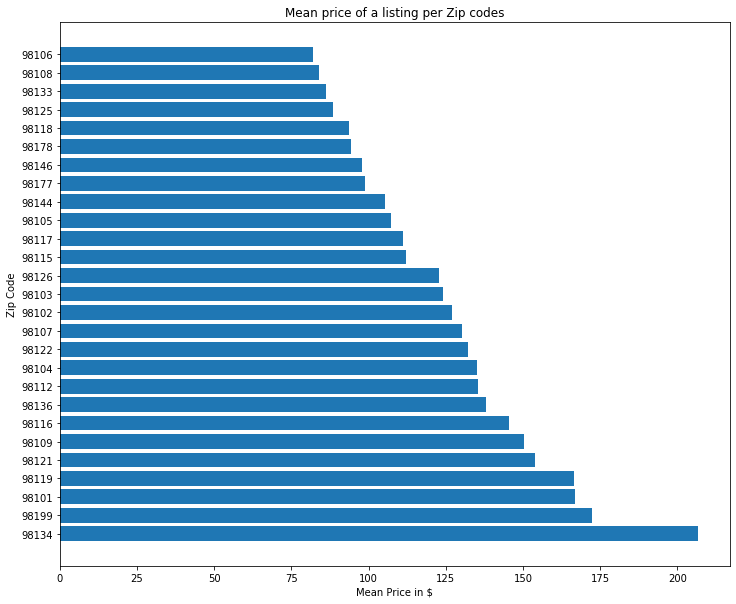

In [25]:
dfgeo = dfgeo.groupby(['zipcode']).mean()
dfgeo.sort_values(by=['price'], inplace=True, ascending=False)
plt.figure(figsize=(12, 10))
plt.barh(y=dfgeo.index, width=dfgeo['price'])
plt.xlabel('Mean Price in $')
plt.ylabel('Zip Code')
plt.title('Mean price of a listing per Zip codes');

I want to try to make a new feature out of "review_scores_rating". I'm interested if higher ratings will be beneficial for a higher price.

In [26]:
df['rating_high'] = df['review_scores_rating'].apply(lambda x: 1 if x >= 75 else 0)
df.drop(['review_scores_rating'], axis=1, inplace=True)

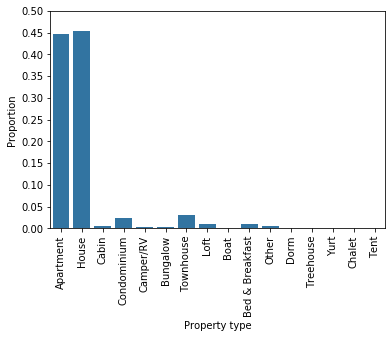

In [27]:
makeCountplot(df, 'property_type', 'Property type', 90)

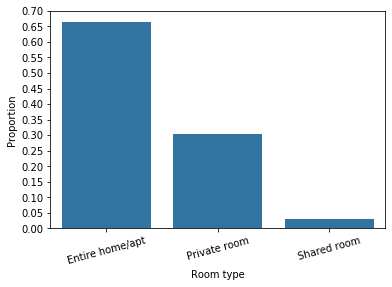

In [28]:
makeCountplot(df, 'room_type', 'Room type', 15)

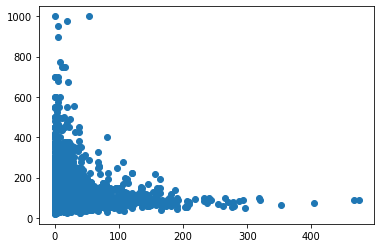

In [29]:
plt.scatter(x=df["number_of_reviews"], y=df["price"]);

Text(0, 0.5, 'Price in $')

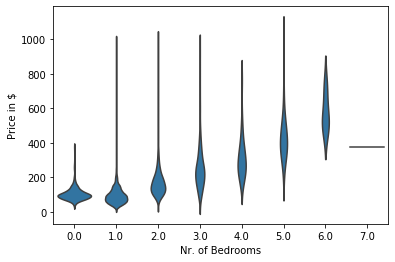

In [30]:
sns.violinplot(data = df, x = 'bedrooms', y = 'price', color = base_color,
              inner = None)
plt.xlabel('Nr. of Bedrooms')
plt.ylabel('Price in $')

There seems to be a linear relationship between the number of bedrooms and the price which comes at no surprise.

Text(0, 0.5, 'Price in $')

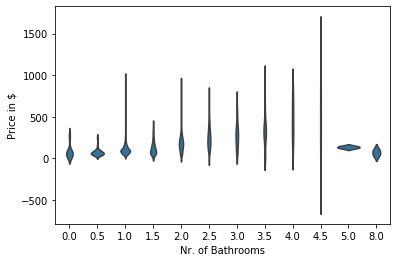

In [31]:
sns.violinplot(data = df, x = 'bathrooms', y = 'price', color = base_color,
              inner = None)
plt.xlabel('Nr. of Bathrooms')
plt.ylabel('Price in $')

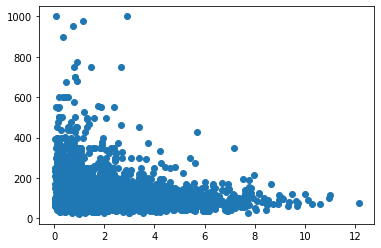

In [32]:
plt.scatter(x=df["reviews_per_month"], y=df["price"]);

(array([105., 411., 548., 627., 553., 380., 349., 183., 105., 130.,  72.,
         99.,  18.,  34.,  49.,  17.,  39.,   5.,  11.,  21.,   5.,  15.,
          2.,   4.,   9.,   1.,   1.,   6.,   1.,   4.,   0.,   0.,   0.,
          2.,   3.,   0.,   0.,   3.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   1.,   1.,   2.]),
 array([  20. ,   39.6,   59.2,   78.8,   98.4,  118. ,  137.6,  157.2,
         176.8,  196.4,  216. ,  235.6,  255.2,  274.8,  294.4,  314. ,
         333.6,  353.2,  372.8,  392.4,  412. ,  431.6,  451.2,  470.8,
         490.4,  510. ,  529.6,  549.2,  568.8,  588.4,  608. ,  627.6,
         647.2,  666.8,  686.4,  706. ,  725.6,  745.2,  764.8,  784.4,
         804. ,  823.6,  843.2,  862.8,  882.4,  902. ,  921.6,  941.2,
         960.8,  980.4, 1000. ]),
 <a list of 50 Patch objects>)

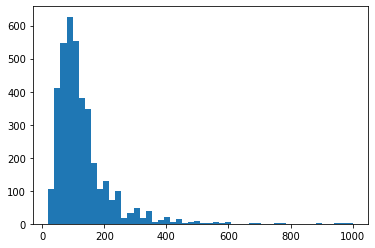

In [33]:
plt.hist(df["price"], 50)

In [34]:
df_num = df.select_dtypes(include=['number'])
df_num.columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'number_of_reviews',
       'reviews_per_month', 'amenities_len', 'rating_high'],
      dtype='object')

In [35]:
df.describe()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,reviews_per_month,amenities_len,rating_high
count,3295.000000,3045.000000,3818.000000,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,3818.000000,3818.000000,3191.000000,3818.000000,3818.000000
mean,94.886798,99.967159,0.203772,7.157757,7.157757,0.997643,0.784966,3.349398,1.259469,1.307712,1.735394,127.976166,22.223415,2.078919,14.358827,0.816920
std,11.866705,1.812201,0.402854,28.628149,28.628149,0.048501,0.410900,1.977599,0.590369,0.883395,1.139480,90.250022,37.730892,1.822348,4.741425,0.386783
min,17.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,20.000000,0.000000,0.020000,0.000000,0.000000
25%,98.000000,100.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,75.000000,2.000000,0.695000,11.000000,1.000000
50%,100.000000,100.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,100.000000,9.000000,1.540000,14.000000,1.000000
75%,100.000000,100.000000,0.000000,3.000000,3.000000,1.000000,1.000000,4.000000,1.000000,2.000000,2.000000,150.000000,26.000000,3.000000,17.000000,1.000000
max,100.000000,100.000000,1.000000,502.000000,502.000000,1.000000,1.000000,16.000000,8.000000,7.000000,15.000000,1000.000000,474.000000,12.150000,30.000000,1.000000


"host_listings_count" and "host_total_listings_count" have exactly the same statistics so I think this variable is a double. I'll delete "host_total_listings_count" from the data set and keep only "host_listings_count" for my analysis.

In [36]:
df = df.drop('host_total_listings_count', axis=1)

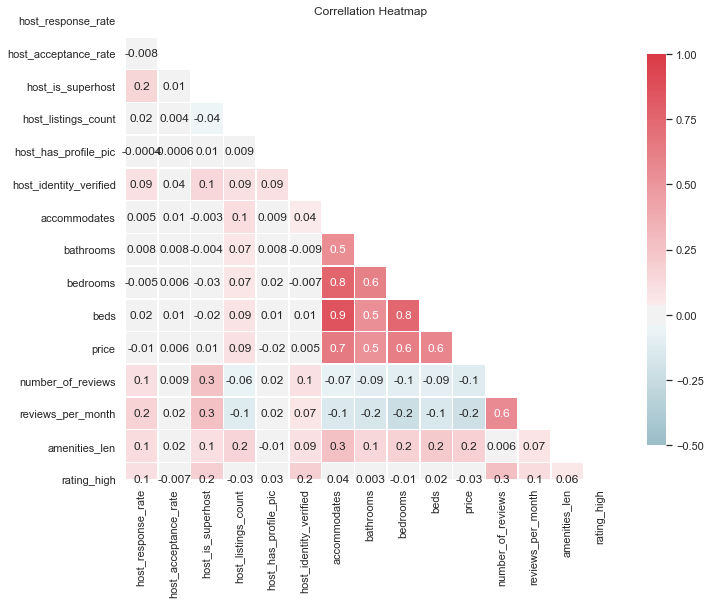

In [37]:
sns.set(style="white")

# Compute the correlation matrix 'top90', 'upto25', .drop(['scrape_id', 'license'], axis=1)
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot=True, fmt='.00')
plt.title('Correllation Heatmap');

We can clearly see that the following variables are at least moderately correllated to the price: accomodates, bathrooms, bedrooms, beds. This comes at no surprise as you would expect that bigger appartments tend to have a higher price.

To use categorical variables in a linear regression model we first have to convert them to numerical variables. So I'll create dummy variables for all categorical variables.

In [38]:
df = create_dummy_df(df, ['host_response_time', 'property_type', 'room_type', 'zipcode'], dummy_na=False)
df

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,...,zipcode_98126,zipcode_98133,zipcode_98134,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98177,zipcode_98178,zipcode_98199,zipcode_99\n98122
0,96.0,100.0,0,3.0,1,1,4,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,98.0,100.0,1,6.0,1,1,4,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,67.0,100.0,0,2.0,1,1,11,4.5,5.0,7.0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,NaN,0,1.0,1,1,3,1.0,0.0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,100.0,NaN,0,2.0,1,1,6,2.0,3.0,3.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,99.0,100.0,0,354.0,1,1,6,2.0,3.0,3.0,...,0,0,0,0,0,0,0,0,0,0
3814,100.0,100.0,0,1.0,1,1,4,1.0,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
3815,NaN,NaN,0,1.0,1,0,2,1.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
3816,100.0,NaN,0,1.0,1,1,2,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0


## Predictive Modeling
Preparing data for Regressor

As the "price" is going to be the target that we want to predict let's look at the distribution of the data.

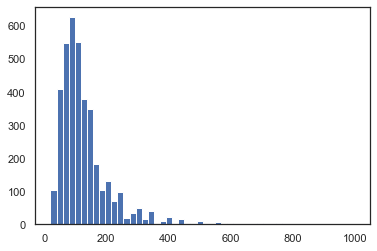

In [39]:
plt.hist(df['price'], 50);

In [40]:
df['price'].describe()

count    3818.000000
mean      127.976166
std        90.250022
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max      1000.000000
Name: price, dtype: float64

The price data is normally distributed but it has some outliers. To make the predictions more accurate and to show which variables really have an impact on the price I am going to focus on prices below 400 Dollar (mean + 3 standard deviations) as these represent approximately 99.7% of the data.

In [41]:
df = df[df['price']<400]

In [42]:
# Mean function
fill_mean = lambda col: col.fillna(col.mean())
# Imputing values with the mean
#df[['host_response_rate', 'host_acceptance_rate']] = df[['host_response_rate', 'host_acceptance_rate']].apply(fill_mean, axis=0)

#as imputing these columns has lead to lower scores on the models I've decided to just drop
#all NA values. We still have enough values to build a good model.

#dropping na values
df = df.dropna()

# Split into explanatory and response variables
X = df.drop('price', axis=1)
y = df['price']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

## Evaluating models

In [55]:
modelCompList = []

### 1. Linear Regression model

test score: 0.6797036051869625
train score: 0.6718607004740033
RMSE: 38.1628


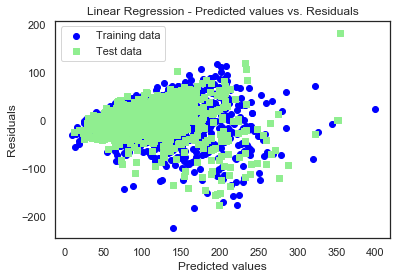

In [56]:
lm_model = LinearRegression(normalize=False)  # Instantiate
model, test_score, train_score, rmse = fitAndScoreModel(X_train, y_train, lm_model)
plotPredVsResiduals(model, 'Linear Regression')
modelCompList.append(['Linear Regression', test_score, train_score, rmse])

In [44]:
coeff_df = pd.DataFrame(lm_model.coef_, X.columns, columns=['Coefficient'])  
coeff_df = coeff_df.sort_values(by=['Coefficient'], ascending=True)
print(coeff_df.head(30))
print(coeff_df.tail(31))

                        Coefficient
room_type_Shared room    -68.923583
property_type_Dorm       -65.878047
zipcode_98133            -61.470153
zipcode_98178            -58.713612
zipcode_98118            -49.394362
zipcode_98106            -48.458263
zipcode_98108            -48.092713
zipcode_98177            -47.089718
zipcode_98125            -45.697583
zipcode_98126            -41.094159
zipcode_98117            -40.804846
room_type_Private room   -38.558733
zipcode_98105            -38.118146
zipcode_99\n98122        -37.642470
zipcode_98136            -37.383275
zipcode_98115            -36.723153
zipcode_98144            -35.244062
zipcode_98146            -31.823472
zipcode_98103            -31.094005
zipcode_98116            -25.871280
zipcode_98107            -22.066465
zipcode_98112            -20.231955
zipcode_98122            -19.737106
zipcode_98119            -16.394073
zipcode_98102            -14.356805
zipcode_98109             -8.672110
zipcode_98199             -8

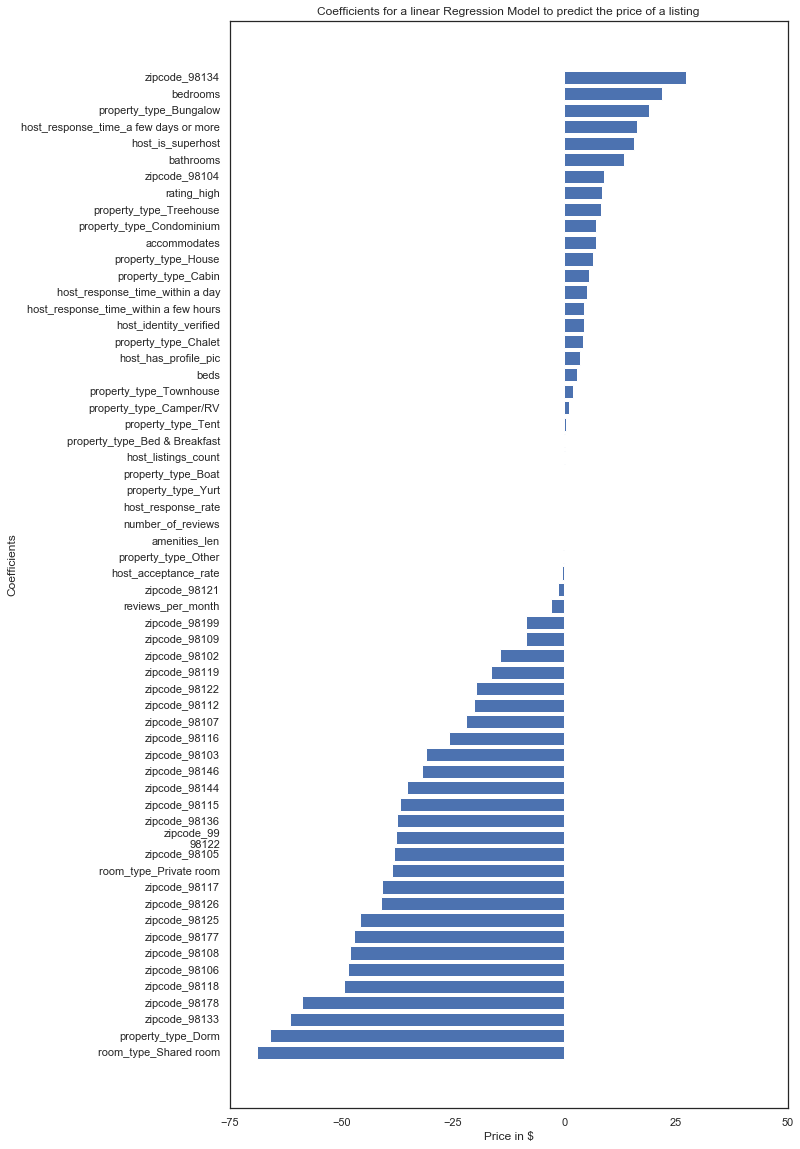

In [52]:
plt.figure(figsize=(10, 20))
plt.barh(coeff_df.index[:60], coeff_df['Coefficient'][:60])
plt.xticks(range(-75,75,25))
plt.title('Coefficients for a linear Regression Model to predict the price of a listing')
plt.xlabel('Price in $')
plt.ylabel('Coefficients')
plt.show()

As we can see the Property and Room Type of an Airbnb listing can have a huge influence on the price. For instance a dorm or a shared room on average has a price that is 65-70 Dollar lower than the average price for an apartment while on the other side special locations like a boat, a treehouse, a loft or a yurt cost more than the standard apartment. Even a private room  on average has a price that is 38 Dollar lower than an entire home/apartment. Also the location of the listing is important. there are a few zip codes where the price is higher than the average (up to ca 27 Dollar). I guess that these zip codes represent the most wanted areas in Seattle while most other zip codes lower the price by up to 61 Dollar on average.

We can also state that having more bedrooms also correlates with a higher price. Per additional bedroom the price increases by  22 Dollar on average while an additional bathroom usually correlates with a 13 Dollar price increase. 

If the listing has a rating that is greater than 75 it usually has a higher price of ca. 8 Dollar. If the host has a "superhost" status the price of the listing is 15$ higher than the average price. The number of reviews per month negatively correlates with the price (ca. 3 Dollar per rating). Maybe you're more motivated to write a review if you've had a negative experience than customers who had a good experience.

The amount of amenities that come with the listing don't seem to have any influence on the price of a listing. 


## 2. Lasso

test score: 0.6617004618797873
train score: 0.6608696460216096
RMSE: 39.2206


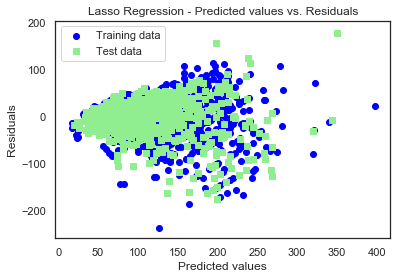

In [57]:
lassoReg = Lasso(alpha=0.1, normalize=False, random_state=42)
model, test_score, train_score, rmse = fitAndScoreModel(X_train, y_train, lassoReg)
plotPredVsResiduals(model, 'Lasso Regression')
modelCompList.append(['Lasso Regression', test_score, train_score, rmse])

## 3. Ridge Regression

test score: 0.676801800560308
train score: 0.6714840302169102
RMSE: 38.3353


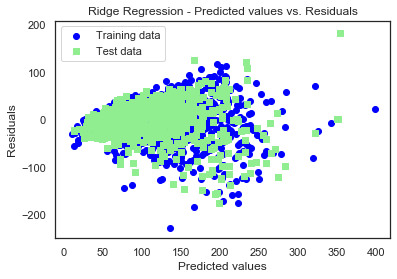

In [58]:
ridgeReg = Ridge(alpha=.5)
ridgeReg.fit(X_train, y_train)
model, test_score, train_score, rmse = fitAndScoreModel(X_train, y_train, ridgeReg)
plotPredVsResiduals(model, 'Ridge Regression')
modelCompList.append(['Ridge Regression', test_score, train_score, rmse])

## 4. Random Forest

test score: 0.6920159612419192
train score: 0.95301386217569
RMSE: 37.4221


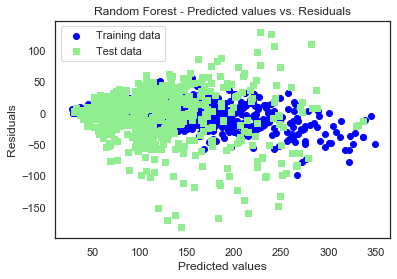

In [60]:
forest = RandomForestRegressor(n_estimators=600, 
                               criterion='mse', 
                               random_state=42, 
                               n_jobs=-1)
model, test_score, train_score, rmse = fitAndScoreModel(X_train, y_train, forest)
plotPredVsResiduals(model, 'Random Forest')
modelCompList.append(['Random Forest', test_score, train_score, rmse])

## 5. Gradient Boost

test score: 0.686202762697615
train score: 0.7692033952297361
RMSE: 37.7736


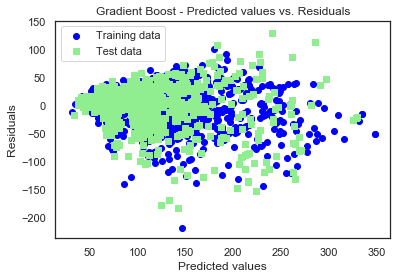

In [61]:
gbr = GradientBoostingRegressor(n_estimators=500, max_depth=4, min_samples_split=2,
          learning_rate=0.01, loss='ls')
model, test_score, train_score, rmse = fitAndScoreModel(X_train, y_train, gbr)
plotPredVsResiduals(model, 'Gradient Boost')
modelCompList.append(['Gradient boost', test_score, train_score, rmse])

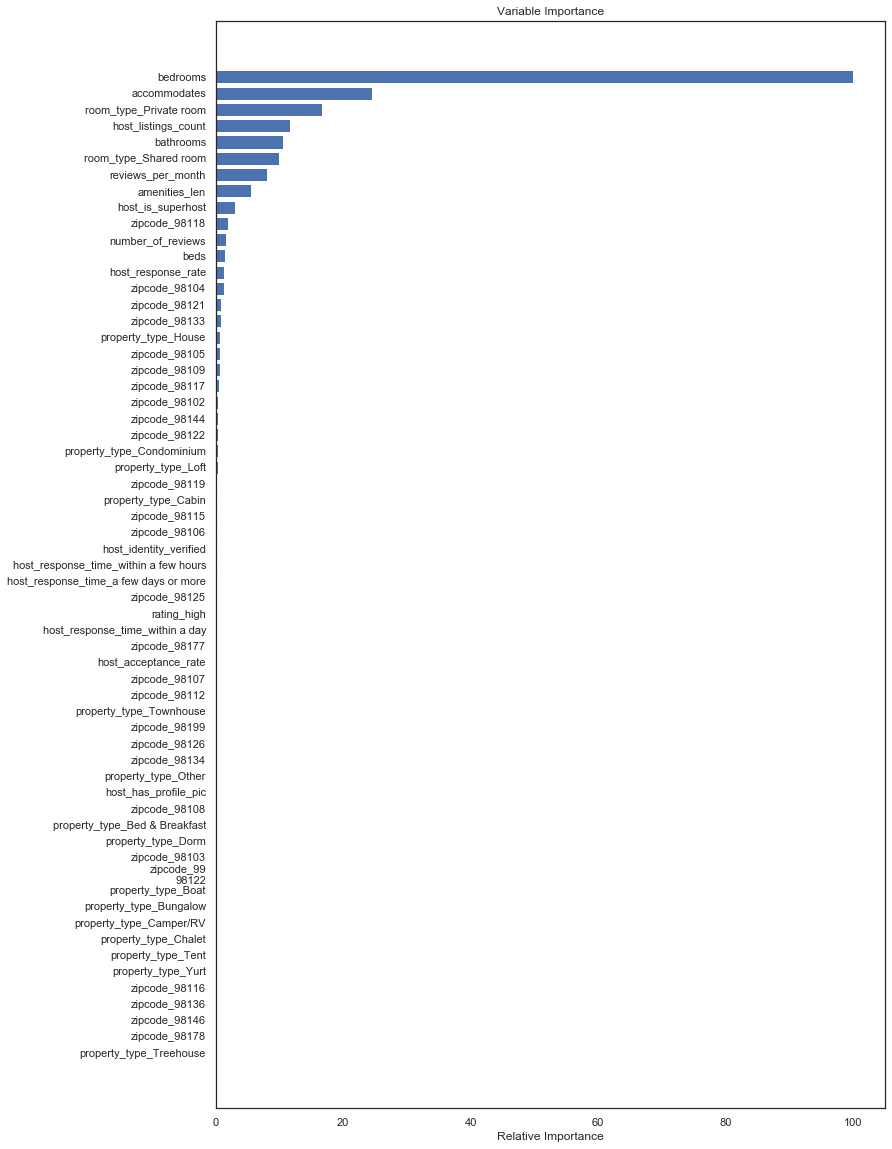

In [50]:
plotFeatureImportance(X_train, model)

As you can tell from the plot the number of bedrooms, bathrooms and accomodates are the most influential variable for predicting the price as these all are indicating a bigger appartment or house. But these 3 variables doesn't explain all the variance of the price. The Rating from the customer reviews also has an influence so landlords should care about making their renters stay as pleasant as possible. Some zipcodes also have an influence on the price so the location of the apartment does matter too.

Wether you are a superhost or not or if you've got your identity verified or not doesn't really impact the price of the listing much.

In [63]:
df_modelComp = pd.DataFrame(data=modelCompList, columns=['model','test_score', 'train_score', 'rmse'])

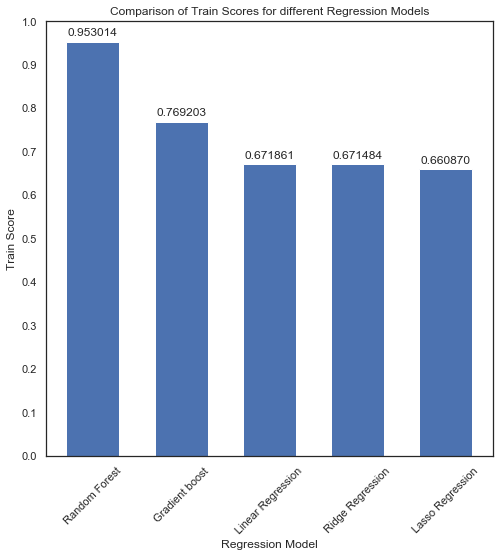

In [127]:
df_modelComp = df_modelComp.sort_values(by=['train_score'], ascending=False)
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
plt.bar(x=df_modelComp['model'], height=df_modelComp['train_score'], width=0.6, color='blue')
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 1.05, 0.1))
plt.xlabel('Regression Model')
plt.ylabel('Train Score')
plt.title('Comparison of Train Scores for different Regression Models')

rects = ax.bar(np.arange(5), df_modelComp['train_score'], 0.6)
for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%f' % height,
                ha='center', va='bottom')

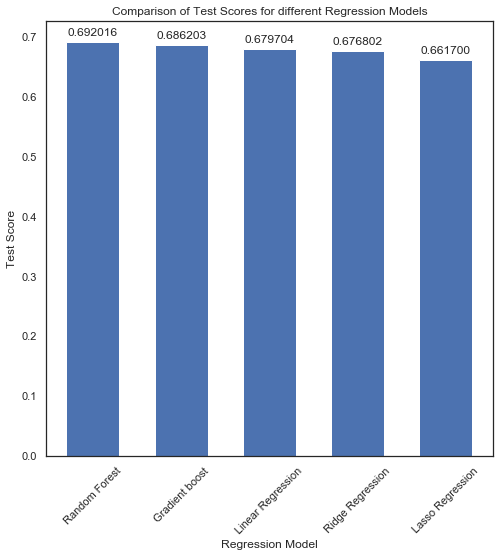

In [128]:
df_modelComp = df_modelComp.sort_values(by=['test_score'], ascending=False)
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
plt.bar(x=df_modelComp['model'], height=df_modelComp['test_score'], width=0.6, color='blue')
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 1.05, 0.1))
plt.xlabel('Regression Model')
plt.ylabel('Test Score')
plt.title('Comparison of Test Scores for different Regression Models')

rects = ax.bar(np.arange(5), df_modelComp['test_score'], 0.6)
for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%f' % height,
                ha='center', va='bottom')

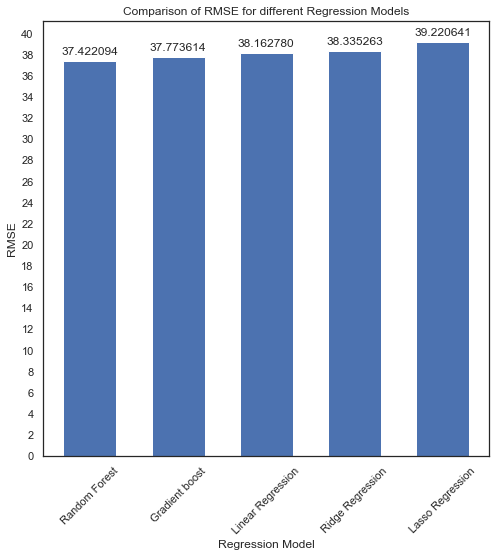

In [110]:
df_modelComp = df_modelComp.sort_values(by=['rmse'])
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
plt.bar(x=df_modelComp['model'], height=df_modelComp['rmse'], width=0.6, color='blue')
plt.xticks(rotation=45)
plt.yticks(range(0, 45, 2))
plt.xlabel('Regression Model')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE for different Regression Models')

rects = ax.bar(np.arange(5), df_modelComp['rmse'], 0.6)
for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%f' % height,
                ha='center', va='bottom')